# Post-COVID Travel Plans (Seattle)

## 1. Business Question

Post COVID, the appetite to travel will likely increase. Using the Data from Airbnb, I want to understand the following:

1. Is there a seasonality trend with Airbnb Seattle Rentals throughout the year?
2. What are the type of Rentals available during the Christmas Holiday?
3. Where are the rentals with the most ammenities during the Christmas Holiday?

## 2. Data Gather / Cleaning

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
listings_df = pd.read_csv('data/listings.csv')
calendar_df = pd.read_csv('data/calendar.csv',parse_dates=['date'])
reviews_df = pd.read_csv('data/reviews.csv')

### 1. Is there a seasonality trend with Airbnb Seattle Rentals throughout the year?

### Data Preparation

In [3]:
print(calendar_df.info(),calendar_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB
None    listing_id       date available   price
0      241032 2016-01-04         t  $85.00
1      241032 2016-01-05         t  $85.00
2      241032 2016-01-06         f     NaN
3      241032 2016-01-07         f     NaN
4      241032 2016-01-08         f     NaN


A quick exploration shows the following:

* There is an available field which is a string, which will help us answer this question
* There are null values in Price on the days that rentals were not occupied
* Price format is not analytics friendly so will need transform that column for analysis
* Price is NULL in cases where it was not booked, this will skew any analysis on price. I will combat this will removing those rows when doing analysis on price.

In [4]:
calendar_df['year_month']=calendar_df['date'].dt.strftime('%Y-%m')

# Problem:There is an available field which is a string, which will help us answer this question
# Solution: Creating new column with a binary flag to indicate if the rental was occupied
calendar_df['occupied']=calendar_df.apply(lambda row: 1 if row.available=='f' else 0, axis=1)

In [5]:
# Problem: Price format is not analytics friendly so will need transform that column for analysis
# Solution: Remove characters + convert to float

calendar_df['price']=calendar_df['price'].str.replace('$','')
calendar_df['price']=calendar_df['price'].str.replace(',','')
calendar_df['price']=calendar_df['price'].str.replace('.00','')

calendar_df['price']=calendar_df.apply(lambda row: float(row.price) if row.available=='t' and row.price!='' else np.nan, axis=1)

### Evaluation

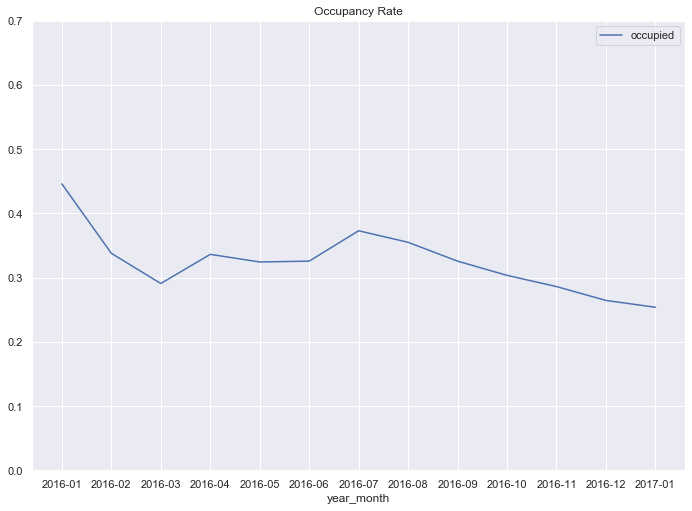

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
occupancy_by_date_df   = calendar_df.groupby(['year_month']).mean().drop(columns=['listing_id','price'],axis=1)

occupancy_by_date_plt = sns.lineplot(data=occupancy_by_date_df)
occupancy_by_date_plt.set(ylim=(0, 0.7),title='Occupancy Rate')
occupancy_by_date_plt

Few quick takeaways from the trend observed:
* Occupancy Rate declines rapidly during the first quarter of the years.
* Uptick observed in April / July, possibly driven by festivals, activities during Spring / Summer months
* The occupancy rate drops significantly into the winter, possibly driven due to weather (high precipitation months)

As a quick follow up, I want to check if there is seasonality trend in the Avg. price of the rentals...
* Since the price is NULL in cases where the listing is not booked, I will only select listings where the price is available (i.e. listing is occupied) for this part of the analysis.

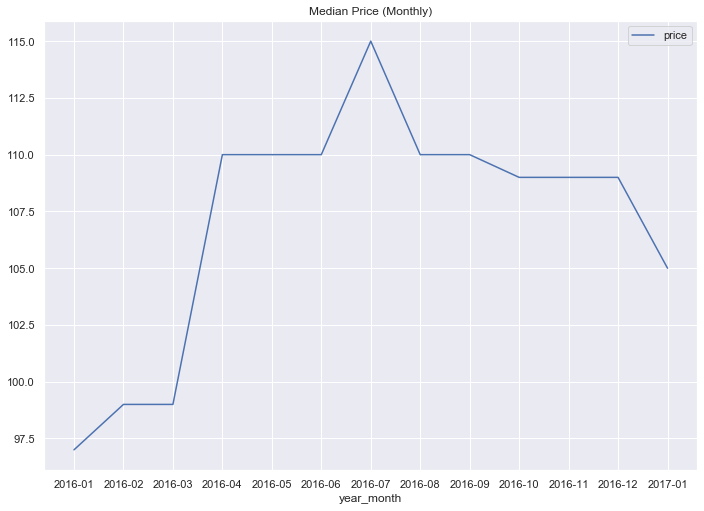

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
monthly_median_price_df = calendar_df[calendar_df.occupied==0].groupby(['year_month']).median().drop(columns=['listing_id','occupied'],axis=1)
monthly_median_price_df = sns.lineplot(data=monthly_median_price_df)
monthly_median_price_df.set(title='Median Price (Monthly)')
monthly_median_price_df

Few quick takeaways:
* Observing an increase in Median Price during the Summer Months
* Observing the price to drop into the winter months in line with the trend observed in Occupancy rate 

Final Conclusions:
* Occupancy Rate highest the first 3 months of 2016, with lowest median prices of $97-$100
* Highest median pricing observed during the summer months
* Occupancy and pricing drops in the winter months likely driven by high precipitation in Seattle.

### 2. What are the type of Rentals available during the Christmas Holiday?

### Data Prep

In [18]:
calendar_q2= calendar_df[(calendar_df['date']>= "2016-12-01") & (calendar_df['date']<= "2016-12-31")]
calendar_q2= calendar_q2[calendar_df.occupied==0]
listings_q2= listings_df[['id','name','property_type','bed_type']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 4 columns):
id               3818 non-null int64
name             3818 non-null object
property_type    3817 non-null object
bed_type         3818 non-null object
dtypes: int64(1), object(3)
memory usage: 119.4+ KB


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [33]:
q2_df = pd.merge(calendar_q2, listings_q2, how='left', left_on='listing_id', right_on='id')
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87061 entries, 0 to 87060
Data columns (total 10 columns):
listing_id       87061 non-null int64
date             87061 non-null datetime64[ns]
available        87061 non-null object
price            80543 non-null float64
year_month       87061 non-null object
occupied         87061 non-null int64
id               87061 non-null int64
name             87061 non-null object
property_type    87030 non-null object
bed_type         87061 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 7.3+ MB


Observing null values for the "Property Type" / "Price" fields, since I will be counting unique based on Listing_ID and sample size is large to have representative analysis. I decided to drop the null rows before proceeding the analysis. 

In [34]:
q2_df = q2_df.dropna()
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80512 entries, 0 to 87060
Data columns (total 10 columns):
listing_id       80512 non-null int64
date             80512 non-null datetime64[ns]
available        80512 non-null object
price            80512 non-null float64
year_month       80512 non-null object
occupied         80512 non-null int64
id               80512 non-null int64
name             80512 non-null object
property_type    80512 non-null object
bed_type         80512 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 6.8+ MB


### Evaluation

[Text(0.5, 1.0, 'Top 5 Property Types Available')]

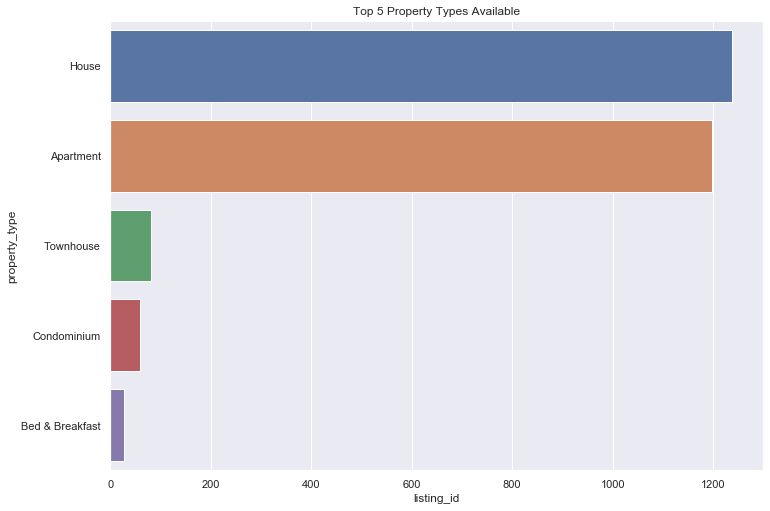

In [35]:
property_chk = q2_df.groupby('property_type')['listing_id'].nunique().reset_index()

top_5 = property_chk.sort_values('listing_id',ascending=False).head(5)
top_5_plt=sns.barplot(y="property_type", x="listing_id",data=top_5,orient='h')
top_5_plt.set(title='Top 5 Property Types Available')

Quick Takeaway:
* Property Type available during December seems to be mostly Houses / Apartment

[Text(0.5, 1.0, 'Top 5 Bed Types Available')]

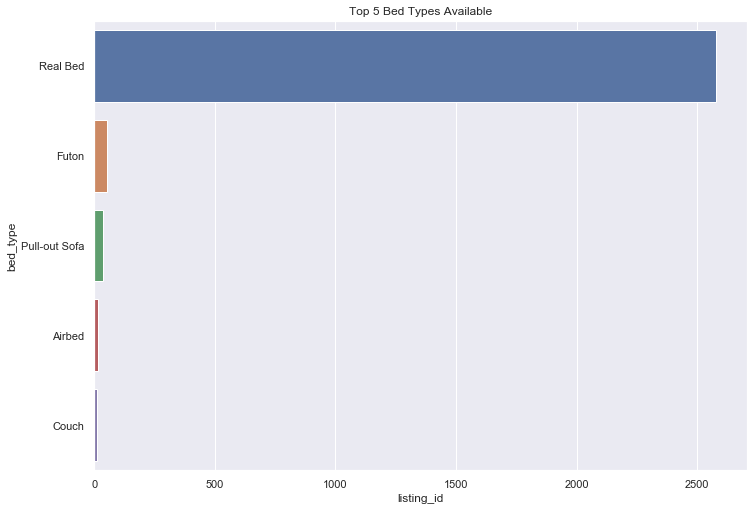

In [36]:
bed_type_chk = q2_df.groupby('bed_type')['listing_id'].nunique().reset_index()

top_5 = bed_type_chk.sort_values('listing_id',ascending=False).head(5)
top_5_plt=sns.barplot(y="bed_type", x="listing_id",data=top_5,orient='h')
top_5_plt.set(title='Top 5 Bed Types Available')

Quick Takeaway:
* Most listing available will have a listing with a bed

### 3. Where are the rentals with the most ammenities during the Christmas Holiday?

### Data Prep

In [37]:
calendar_q3= calendar_df[(calendar_df['date']>= "2016-12-01") & (calendar_df['date']<= "2016-12-31")]
calendar_q3= calendar_q3[calendar_df.occupied==0]
listings_q3= listings_df[['id','amenities','neighbourhood_cleansed','smart_location','market']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In order to the analysis I need to normalize the Amenities by getting the count of number of amenities available for a given listing. 

In [38]:
def convert_amenities(x):
    """ 
    The function takes a string removes characters and converts to a list. 
  
    Parameters: 
    x (str): the input string to clean up
  
    Returns: 
    x: the list of amenities
    """
    
    x=x.replace('{','')
    x=x.replace('}','')
    x=x.replace('"','')

    return x.split(',')

In [39]:
listings_q3['amenties_agg']=listings_q3.apply(lambda row: len(convert_amenities(row.amenities)),axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
q3_df = pd.merge(listings_q3,calendar_q3, how='inner', right_on='listing_id', left_on='id')

### Evaluation 

[Text(0.5, 1.0, 'Top 5 Neighborhoods with Most Amenities in December')]

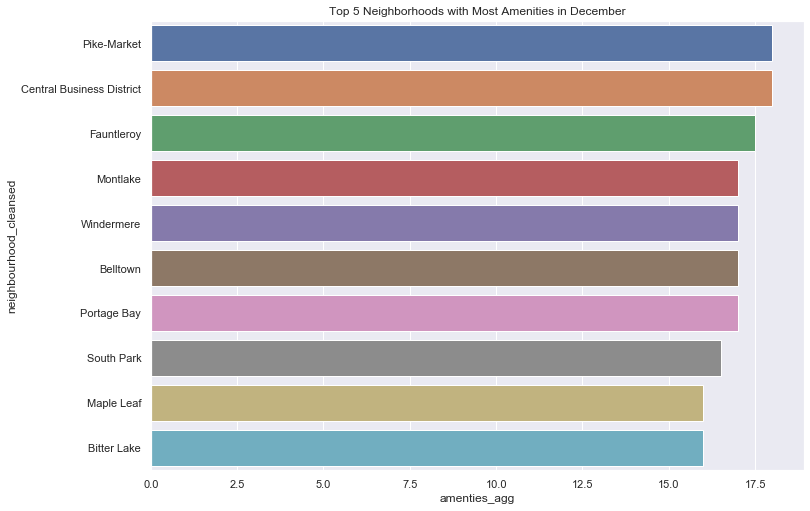

In [44]:
neighborhood_chk = q3_df.groupby('neighbourhood_cleansed')['amenties_agg'].median().reset_index()

top_10 = neighborhood_chk.sort_values('amenties_agg',ascending=False).head(10)
top_10_plt = sns.barplot(y="neighbourhood_cleansed", x="amenties_agg",data=top_10,orient='h')
top_10_plt.set(title='Top 5 Neighborhoods with Most Amenities in December')

Quick Takeaway:
* For the available listings in December, Pike Market / Central Business Distict have the most amenities. 